<a href="https://colab.research.google.com/github/vincenthanna/maic/blob/main/MAIC_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
BASE_DIR = "/content/drive/My Drive/data/maic"
FILE_TRAIN_CASES = "/content/drive/My Drive/data/maic/train_cases.csv"
df_tc = pd.read_csv(FILE_TRAIN_CASES)
df_tc.head(10)

,caseid,age,sex,weight,height
0,1,77,M,67.50,160.2
1,4,74,M,53.00,160.6
2,7,52,F,62.30,167.7
3,10,72,M,62.75,162.5
4,13,67,F,64.90,153.0
5,16,57,M,68.90,162.3
6,17,85,M,53.00,164.2
7,19,74,M,66.20,171.3
8,20,75,M,61.30,173.6
9,22,53,F,54.60,162.0


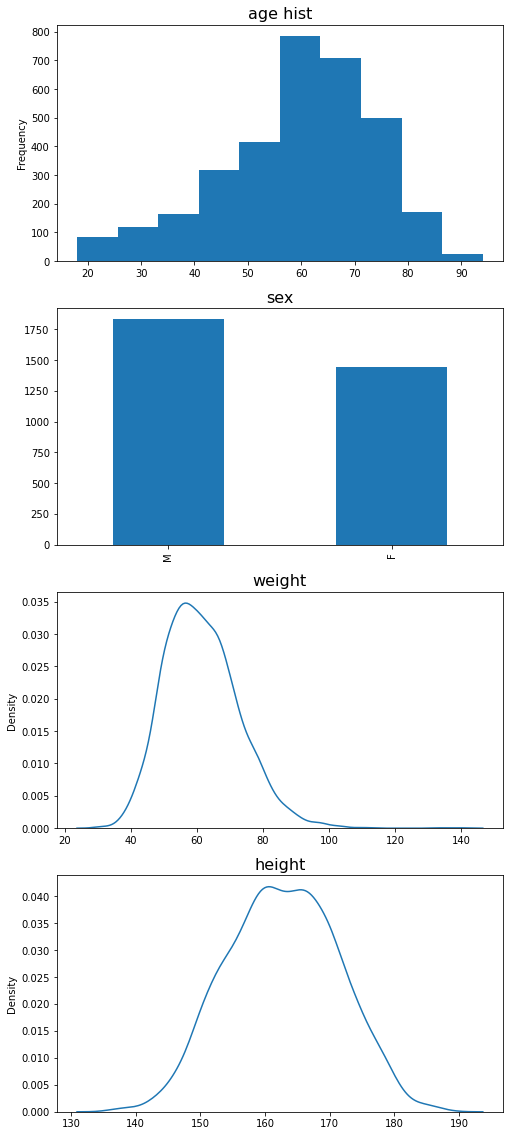

In [ ]:
# check demographic info data.

import seaborn as sns

plt.rc('axes', titlesize=16)

fig, ax = plt.subplots(4, 1, figsize=(8, 5 * 4))
ax[0].set_title('age hist')
df_tc['age'].plot.hist(ax=ax[0])

ax[1].set_title('sex')
df_tc['sex'].value_counts().plot.bar(ax=ax[1])

ax[2].set_title('weight')
weights = df_tc['weight'].values
sns.kdeplot(data=weights, ax=ax[2])

ax[3].set_title('height')
heights = df_tc['height'].values
sns.kdeplot(data=heights, ax=ax[3])

In [ ]:
def moving_average(a, n=200):
    '''
    각각 size=n 만큼의 윈도우의 평균값을 갖게한다.
    '''
    ret = np.nancumsum(a, dtype=np.float32) # 누적합 배열을 만든다.        
    '''
    ret[:-n] 처음부터 시작, 끝에서 n개 뺀 것까지. (0 ~ len(arr)-n)
    
    ret[n:] = ret[n:] - ret[:-n]
    assume n = 5 :
      5 6 7 8 9 10 11 12 13 ...
    - 0 1 2 3 4  5  6  7  8 ...
    ------------------------
      5 5 5 5 5  5  5 ....

    여기서 ret가 누적합이므로, moving average값이 된다.
    '''
    ret[n:] = ret[n:] - ret[:-n] # window에 포함된 값들의 총합들을 구한다. n개의 합부터 시작
    return ret[n - 1:] / n

a = [i for i in range(20)]
print(a)
print(moving_average(a, n=10))




[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[ 4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5]


## 문제 정의
수술 중 측정된 20초 요골 동맥압 파형으로부터 수술 중 저혈압을 5분 전에 예측하시오 <br>
수술 중 저혈압의 정의: MAP < 65 mmHg 로 1분 이상 지속된 경우 입력 혈압파형에 MAP < 65 mmHg 가 있더라도 예측을 해야합니다.


    X : 20초 동맥압 파형
    Y : 5분(300초) 후 저혈압
        - MAP < 65 가 1분이상 지속


## 데이터 정의
- x_train : 
    - [?, 2000] 데이터 입력 
    - 2000 = 20초 * 100Hz
- y_train : 
    - [?, 1] 0 혹은 1의 저혈압 여부 yes/no



#### 유의한 동맥압 데이터인지를 확인하는 방법(예)

- segment 로 나누고 한 샘플이라도 25 미만 200 이상인 샘플이 있으면 제외
- 동맥압 증감 속도가 3000 mmHg/s 이상인 샘플이 있으면 제외
    - 30Hg/s 이므로 diff값이 30 넘는지 확인

- beat detection 을 하고 (detect_peaks 함수 이용) 각 beat 의 샘플을 동일 길이로 (예컨대 128샘플)만들어 평균 비트를 구한 다음 평균 비트와 각 비트의 correlation coefficient 를 구해 0.9 이하인 비트는 비정상 비트로 처리합니다. <br>abnormal beat (**ventricular premature beat** 등)가 50% 이상인 segment 는 사용하지 않습니다.
- segment 의 평균 HR가 30 미만이거나 150 이상이면 제외합니다.


In [ ]:
import pandas as pd
df_tc = pd.read_csv(FILE_TRAIN_CASES)
len(df_tc)



3278

In [ ]:
# As provided in the answer by Divakar
def ffill(arr):
    mask = np.isnan(arr)
    idx = np.where(~mask, np.arange(mask.shape[1]), 0)
    np.maximum.accumulate(idx, axis=1, out=idx)
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out

# My modification to do a backward-fill
def bfill(arr):
    mask = np.isnan(arr)
    idx = np.where(~mask, np.arange(mask.shape[1]), mask.shape[1] - 1)
    idx = np.minimum.accumulate(idx[:, ::-1], axis=1)[:, ::-1]
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out

In [ ]:
x_train = []
x_train_cases = []
y_train = []
x_test = []
x_test_cases = None

import os
import pandas as pd
import gc

sample_rate = 100
MINUTES_AHEAD = 5

BATCH_SIZE = 512

gc.collect()


def min_to_sec(minval):
    return minval * 60


def to_sr(a):
    return sample_rate * a


def make_filename(typename, ext):
    ret = typename + '.' + ext
    ret = os.path.join(BASE_DIR, ret)
    return ret

def fb_fill_1dim(arr):
    arr = arr.reshape((1, -1))
    arr = ffill(arr)
    arr = bfill(arr)
    arr = arr.reshape((-1))
    return arr


info_columns = ['caseid', 'age', 'sex', 'weight', 'height']

def save_train_data(x_train, y_train, x_train_cases):
    print("saving train npz...", flush=True, end='')
    
    fname = make_filename("x_train", "npz")
    try:
        os.remove(fname)
    except:
        pass
    x_train = np.array(x_train, dtype=np.float32)
    x_train -= 65
    x_train /= 65
    np.savez_compressed(fname, x_train)
    
    fname = make_filename("y_train", "npz")
    try:
        os.remove(fname)
    except:
        pass
    y_train = np.array(y_train, dtype=np.float32)
    np.savez_compressed(fname, y_train)
    
    fname = make_filename("x_train_cases", "csv")
    try:
        os.remove(fname)
    except:
        pass
    info_pd = pd.DataFrame(x_train_cases, columns = info_columns)
    info_pd.to_csv(fname, index=False)

    print("done", flush=True)

# train set loading
if os.path.isfile(os.path.join(BASE_DIR, "x_train.npz")):
    print("loading train data...", flush=True, end="")
    x_train = np.load(os.path.join(BASE_DIR, "x_train.npz"))['arr_0']
    y_train = np.load(os.path.join(BASE_DIR, "y_train.npz"))['arr_0']
    x_train_cases = pd.read_csv(os.path.join(BASE_DIR, "x_train_cases.csv"))
    print("done")
else:
    df_tc = pd.read_csv(FILE_TRAIN_CASES)
    for idx, row in df_tc.iterrows():
        caseid = row['caseid']
        age = row['age']
        sex = row['sex']
        weight = row['weight']
        height = row['height']

        info_pack = [caseid, age, sex, weight, height]

        fpath = os.path.join(BASE_DIR, ''.join(['train_data/', str(caseid), '.csv']))
        if os.path.isfile(fpath):
            samples = pd.read_csv(fpath, header=None).values.flatten() # 읽은값이 (x, 1) 이어서 1차원으로 바꿔준다.

            # 20sec (20 00) - 5min (300 00) - 1min (60 00) = 38000 sample

            i = 0
            event_idx = []
            non_event_idx = []
            in_wlen = to_sr(20) # input 사이즈 - 20초 samples
            yidx_start = to_sr(20 + min_to_sec(MINUTES_AHEAD)) # output 크기
            yidx_end = yidx_start + to_sr(min_to_sec(1))
            while i < (len(samples) - yidx_end) :
                # 입력 : +20초간의 MAP
                # 모델 입력으로 쓰인다.
                segx = samples[i : i + in_wlen] # 20sec samples window
                # 출력 : 20초 후부터 5분 후 1분동안의 MAP값
                # 출력값에서 이벤트가 발생했는지 확인해서 모델 출력값을 만든다.
                segy = samples[i + yidx_start : i + yidx_end]                

                """
                np.diff()값들 사이의 차이의 배열을 리턴한다. (len(a) - 1 의 길이를 가짐)
                한번에 30 이상의 값 변화가 존재하는 경우 세그먼트가 invalid한 것으로 간주한다.
                """
                                
                # 결측값 10% 이상이면
                if np.mean(np.isnan(segx)) > 0.1 or \
                    np.mean(np.isnan(segy)) > 0.1 or \
                    np.max(segx) > 200 or np.min(segx) < 20 or \
                    np.max(segy) > 200 or np.min(segy) < 20 or \
                    np.max(segx) - np.min(segx) < 30 or \
                    np.max(segy) - np.min(segy) < 30 or \
                    (np.abs(np.diff(segx[~np.isnan(segx)])) > 30).any() or \
                    (np.abs(np.diff(segy[~np.isnan(segy)])) > 30).any():
                    i += sample_rate # 1 sec씩 전진
                    continue                

                # TODO :
                # beat detection 해서 abnormal beat가 50% 이상인 segment는 사용하지 않는다.
                
                # nan 값을 앞뒤 값을 참고해서 모두 채운다.
                segx = fb_fill_1dim(segx)

                # 출력변수
                segy = moving_average(segy, to_sr(2)) # 2 sec moving average
                event = 1 if np.nanmax(segy) < 65 else 0
                # train 데이터 추가
                event_idx.append(i) if event else non_event_idx.append(i)
                x_train.append(segx)
                y_train.append(event)
                x_train_cases.append(info_pack)
                i = i + to_sr(30)

            nsamp = len(event_idx) + len(non_event_idx)
            if nsamp > 0:
                print('{}: {} ({:.1f}%)'.format(caseid, nsamp, len(event_idx) * 100 / nsamp))        
        
        # FIXME: for test... delete later
        # if idx > 10:
        #     break
           
    # save data
    save_train_data(x_train, y_train, x_train_cases)        


px_train = pd.DataFrame(x_train)
print("x_train has null = ", px_train.isnull().values.any())
px_train.head()

        
# 생성 시 nan을 미리 fill 했으므로 아래 코드는 주석처리함.        
# nan을 이전 값으로 채움
# print("fill train nan values with previous data...", flush=True, end="")
# x_train = pd.DataFrame(x_train).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
# print("done.")

# test set loading
PATH_XTEST_CSV = os.path.join(BASE_DIR, 'x_test_cases.csv')
X_TEST_NPZ = os.path.join(BASE_DIR, "x_test.npz")
if os.path.exists(X_TEST_NPZ) and os.path.exists(PATH_XTEST_CSV):
    print("loading test data..." , flush=True, end='')
    x_test = np.load(X_TEST_NPZ, allow_pickle=True)['arr_0']    
    x_test_cases = pd.read_csv(PATH_XTEST_CSV)
    print("done")
else:
    try:
        os.remove(X_TEST_NPZ)
        os.remove(X_TEST_CSV)
    except:
        pass
    x_test = pd.read_csv(os.path.join(BASE_DIR, 'test2_x.csv'))
    print("saving...", flush=True, end='')
    # age, sex, weight, height가 앞에 있으므로 추출을 해 놓아야 한다.
    x_test_cases = x_test[['age', 'sex', 'weight', 'height']]
    x_test_cases.to_csv(PATH_XTEST_CSV, index=False)
    x_test = x_test.values
    x_test = np.array(x_test[:, 4:], dtype=np.float32)
    x_test = ffill(x_test)
    x_test = bfill(x_test)
    x_test -= 65
    x_test /= 65
    np.savez_compressed(X_TEST_NPZ, x_test)
    print('done', flush=True)

# 미리 nparray에서 nan을 제거했으므로 아래 코드를 주석처리함.
# nan을 이전 값으로 채움
# print("fill test nan values with previous data...", flush=True, end="")
# x_test = pd.DataFrame(x_test).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
# print("done.")

gc.collect()

1: 279 (8.2%)
4: 605 (0.0%)
7: 387 (0.0%)
10: 599 (6.8%)
13: 243 (8.6%)
16: 363 (1.1%)
17: 607 (5.1%)
19: 832 (8.2%)
20: 763 (0.1%)
22: 399 (0.0%)
24: 156 (5.8%)
25: 417 (0.5%)
26: 206 (0.0%)
27: 512 (1.0%)
28: 758 (0.1%)
29: 609 (0.0%)
31: 263 (0.0%)
34: 634 (0.0%)
38: 304 (0.0%)
41: 284 (0.0%)
43: 409 (17.4%)
44: 384 (0.3%)
46: 242 (0.0%)
49: 222 (1.4%)
50: 463 (2.4%)
51: 215 (0.0%)
53: 335 (0.0%)
59: 53 (1.9%)
61: 235 (8.9%)
64: 394 (2.3%)
65: 313 (0.0%)
66: 253 (0.4%)
67: 226 (0.9%)
68: 173 (0.0%)
69: 166 (0.0%)
70: 305 (0.0%)
74: 468 (0.0%)
75: 687 (0.9%)
77: 284 (0.0%)
79: 574 (3.3%)
84: 528 (0.8%)
87: 292 (20.5%)
89: 550 (0.0%)
92: 96 (45.8%)
93: 67 (20.9%)
94: 637 (8.8%)
96: 1116 (1.4%)
98: 161 (0.0%)
101: 349 (0.0%)
103: 286 (0.0%)
104: 309 (43.7%)
105: 503 (10.9%)
108: 253 (20.9%)
110: 184 (0.0%)
112: 282 (3.2%)
114: 479 (0.0%)
116: 331 (14.8%)
117: 311 (6.1%)
118: 890 (10.0%)
119: 407 (0.0%)
124: 32 (6.2%)
125: 547 (0.2%)
126: 110 (0.0%)
128: 228 (0.0%)
130: 449 (0.0%)
132: 

In [ ]:
# As provided in the answer by Divakar
def ffill(arr):
    mask = np.isnan(arr)
    idx = np.where(~mask, np.arange(mask.shape[1]), 0)
    np.maximum.accumulate(idx, axis=1, out=idx)
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out

# My modification to do a backward-fill
def bfill(arr):
    mask = np.isnan(arr)
    idx = np.where(~mask, np.arange(mask.shape[1]), mask.shape[1] - 1)
    idx = np.minimum.accumulate(idx[:, ::-1], axis=1)[:, ::-1]
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out

print(px_train.shape)

a = np.array([[  5.,  np.nan,  np.nan,   7.,   2.,   6.,   5.],
       [  3.,  np.nan,   1.,   8.,  np.nan,   5.,  np.nan],
       [  4.,   9.,   6.,  np.nan,  np.nan,  np.nan,   7.]])

b = np.array([  4.,   9.,   6.,  np.nan,  np.nan,  np.nan,   7.])
print(b.shape)
b = b.reshape((1, -1))
print(b.shape)
b = ffill(b)
b = bfill(b)

b = b.reshape((-1))
print(b)


print(x_test.shape)

(5650, 2000)
(7,)
(1, 7)
[4. 9. 6. 6. 6. 6. 7.]
(99003, 2000)


In [ ]:
print(len(x_train))
print(len(y_train))
print(len(x_test))

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

1990
1990
99003
(1990, 2000)
(1990,)
(99003, 2000)


In [ ]:
x_test_cases.isnull().sum() # no need to worry about NULL values.

age       0
sex       0
weight    0
height    0
dtype: int64

In [ ]:
# cnn 입력으로 쓰기 위해 차원추가 (..., 1)
x_train = x_train[..., None]
x_test = x_test[..., None]

print('train {} ({} events {:.1f}%), test {}'.format(len(y_train), sum(y_train), 100*np.mean(y_train), len(x_test)))

(1990, 2000)
(99003, 2000)
train 1990 (120.0 events 6.0%), test 99003


In [ ]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf

## Modelling

- ResNet 사용
- SENet 사용 (ResNet에 추가)


In [ ]:
num_nodes = [64, 64, 64, 64, 64, 64]
testname = '-'.join([str(num_node) for num_node in num_nodes])
print(testname)

def make_model():
    """build a model
    """
    model = Sequential()
    for num_node in num_nodes:
        model.add(Conv1D(filters=num_node, kernel_size=3, padding='valid'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D())
    model.add(GlobalMaxPool1D())
    model.add(Dense(16, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])

    return model



모델 훈련

In [ ]:
# 출력 폴더를 생성
outdir = "output"
if not os.path.exists(outdir):
    os.mkdir(outdir)
weight_path = os.path.join(outdir, "weights.hdf5")

# 모델 생성
model = make_model()

callbacks = [ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')]

# train model
hist = model.fit(x_train, y_train, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:10}, callbacks=callbacks)

print("Saving trained model...", end="")
open(os.path.join(outdir, "/model.json"), "wt").write(model.to_json())
print("done")


Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 0.9190 - accuracy: 0.6700 - auc: 0.6776
Epoch 00001: val_loss improved from inf to 0.67288, saving model to output/weights.hdf5
4/4 [==============================] - 1s 217ms/step - loss: 0.9190 - accuracy: 0.6700 - auc: 0.6776 - val_loss: 0.6729 - val_accuracy: 0.8392 - val_auc: 0.9070
Epoch 2/100
3/4 [=====================>........] - ETA: 0s - loss: 0.8020 - accuracy: 0.8132 - auc: 0.7837
Epoch 00002: val_loss improved from 0.67288 to 0.62134, saving model to output/weights.hdf5
4/4 [==============================] - 0s 86ms/step - loss: 0.7838 - accuracy: 0.8241 - auc: 0.7985 - val_loss: 0.6213 - val_accuracy: 0.8643 - val_auc: 0.9173
Epoch 3/100
3/4 [=====================>........] - ETA: 0s - loss: 0.7388 - accuracy: 0.8659 - auc: 0.8286
Epoch 00003: val_loss improved from 0.62134 to 0.58558, saving model to output/weights.hdf5
4/4 [==============================] - 0s 57ms/step - loss: 0.7292 - accuracy: 0.8660 

In [ ]:
model.load_weights(weight_path)

In [ ]:
y_pred = model.predict(x_test).flatten()
np.savetxt("pred_y.txt", y_pred)